In [1]:
import numpy as np
import pandas as pd
import scipy

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("cardox.csv")  
df

,date,value
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86
...,...,...
724,2018-07-01,408.71
725,2018-08-01,406.99
726,2018-09-01,405.51
727,2018-10-01,406.00


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    729 non-null    object 
 1   value   729 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.5+ KB
None


In [4]:
df.describe(include = "all")

,date,value
count,729,729.000000
unique,729,NaN
top,1958-03-01,NaN
freq,1,NaN
mean,NaN,353.787229
std,NaN,27.547500
min,NaN,312.660000
25%,NaN,328.570000
50%,NaN,351.410000
75%,NaN,375.990000


In [5]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


[<AxesSubplot: >]

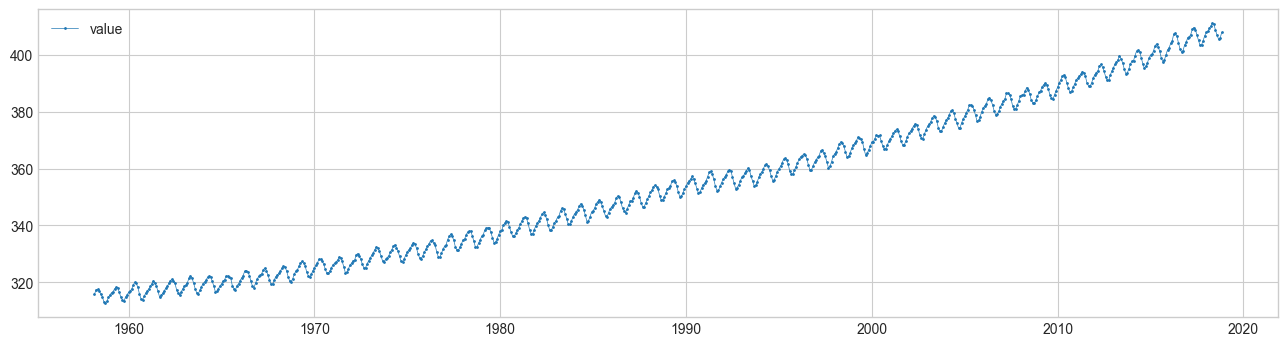

In [6]:
from adtk.visualization import plot
plot(df)

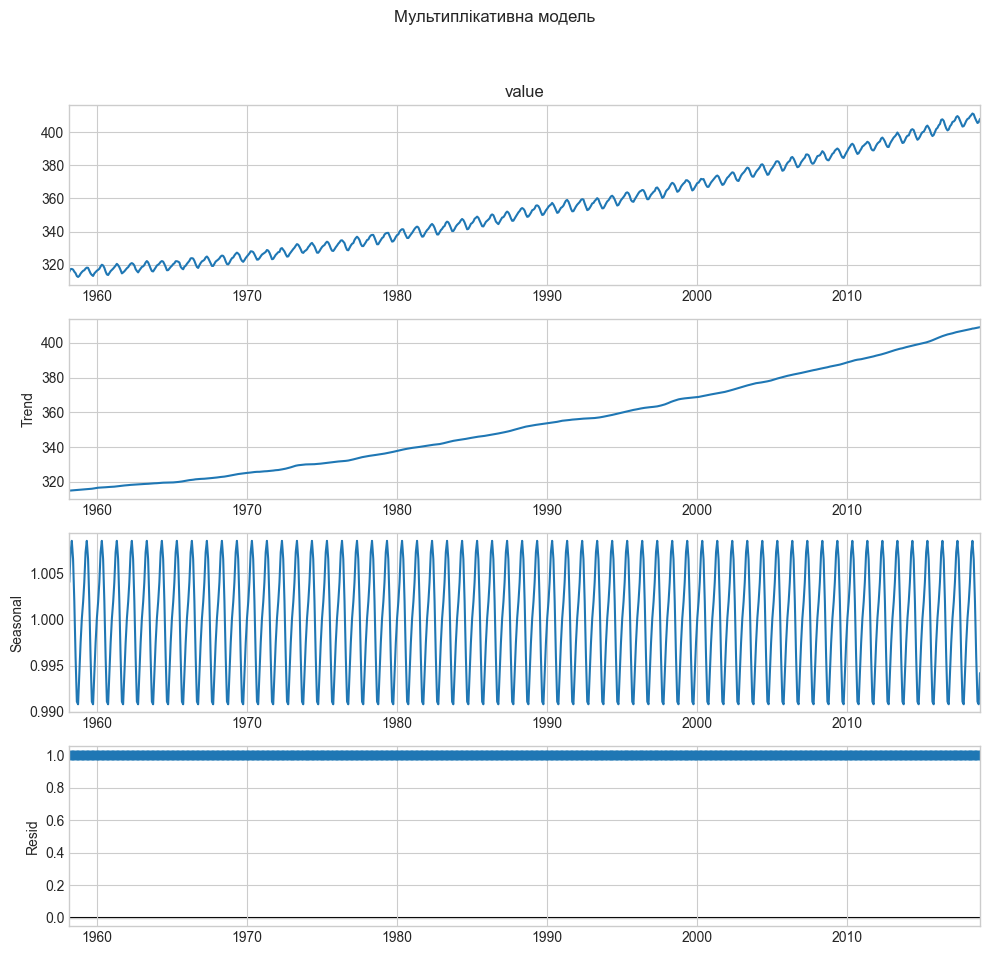

In [7]:
# DECOMPOSITION

from statsmodels.tsa.seasonal import seasonal_decompose

decomp_M = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend=12)

plt.rcParams.update({'figure.figsize': (10,10)})
decomp_M.plot().suptitle('Мультиплікативна модель')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

trend = decomp_M.trend
seasonal = decomp_M.seasonal
residual = decomp_M.resid

In [8]:

# STATIONARITY


In [9]:

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    
    rolmean = timeseries['value'].rolling(12).mean()
    rolstd = timeseries['value'].rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    #plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 


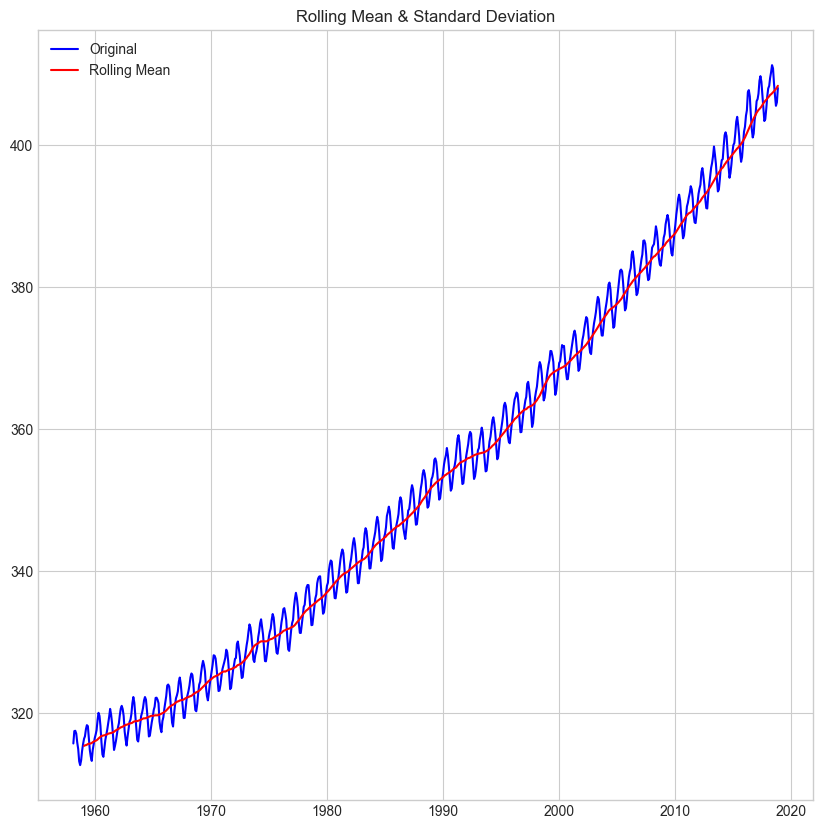

Results of Dickey-Fuller Test:
Test Statistic                   4.994847
p-value                          1.000000
#Lags Used                      20.000000
Number of Observations Used    708.000000
Critical Value (1%)             -3.439620
Critical Value (5%)             -2.865631
Critical Value (10%)            -2.568948
dtype: float64


In [10]:

test_stationarity(df)


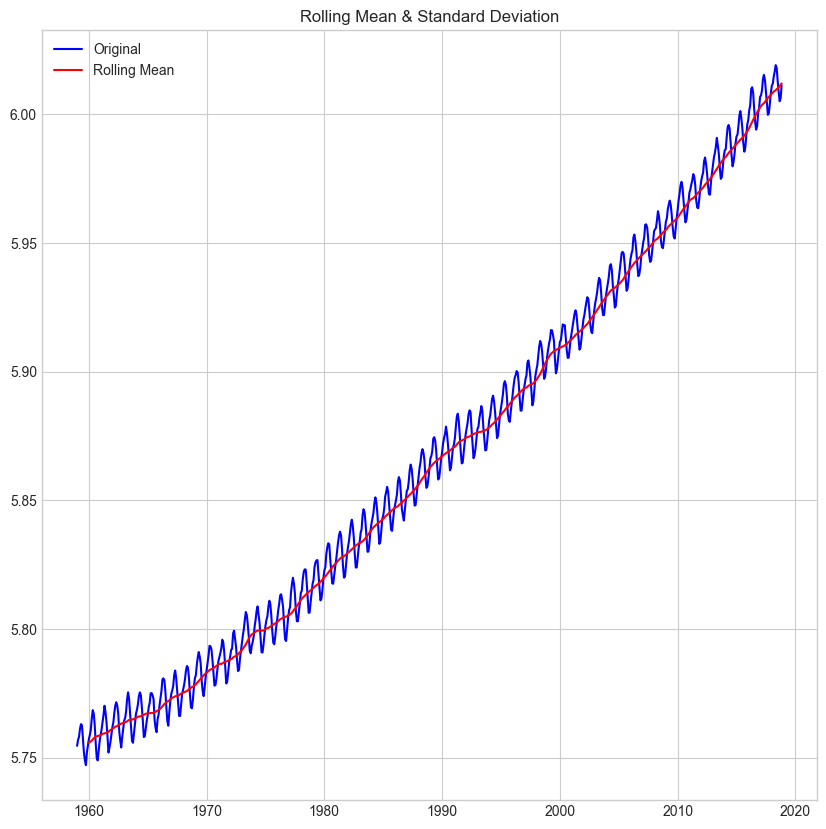

Results of Dickey-Fuller Test:
Test Statistic                   4.033413
p-value                          1.000000
#Lags Used                      20.000000
Number of Observations Used    698.000000
Critical Value (1%)             -3.439753
Critical Value (5%)             -2.865690
Critical Value (10%)            -2.568980
dtype: float64


In [11]:
# log transformation

df=df['1959':'2018']
df_log = np.log(df)

test_stationarity(df_log)

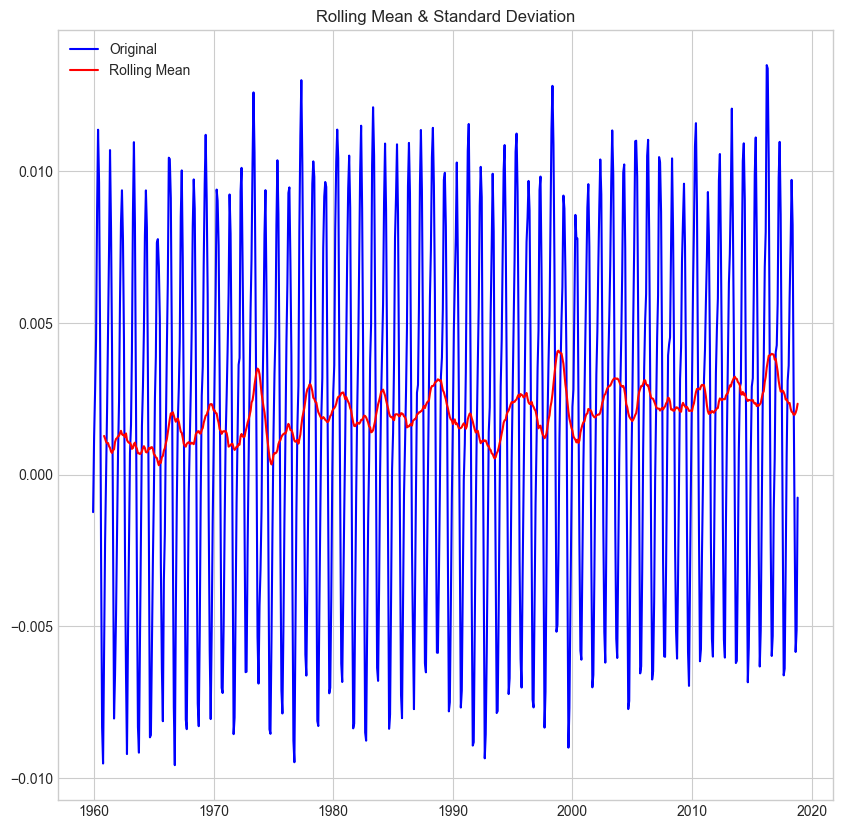

Results of Dickey-Fuller Test:
Test Statistic                -6.040918e+00
p-value                        1.346667e-07
#Lags Used                     1.400000e+01
Number of Observations Used    6.930000e+02
Critical Value (1%)           -3.439821e+00
Critical Value (5%)           -2.865720e+00
Critical Value (10%)          -2.568996e+00
dtype: float64


In [12]:
# moving average

mov_av = df_log['value'].rolling(12).mean()

df_log_mov_av_diff = df_log['value'] - mov_av
df_log_mov_av_diff.dropna(inplace=True)

df_log_mov_av_diff = pd.DataFrame(df_log_mov_av_diff)
df_log_mov_av_diff.head()

test_stationarity(df_log_mov_av_diff)

In [13]:

# SEASONALITY


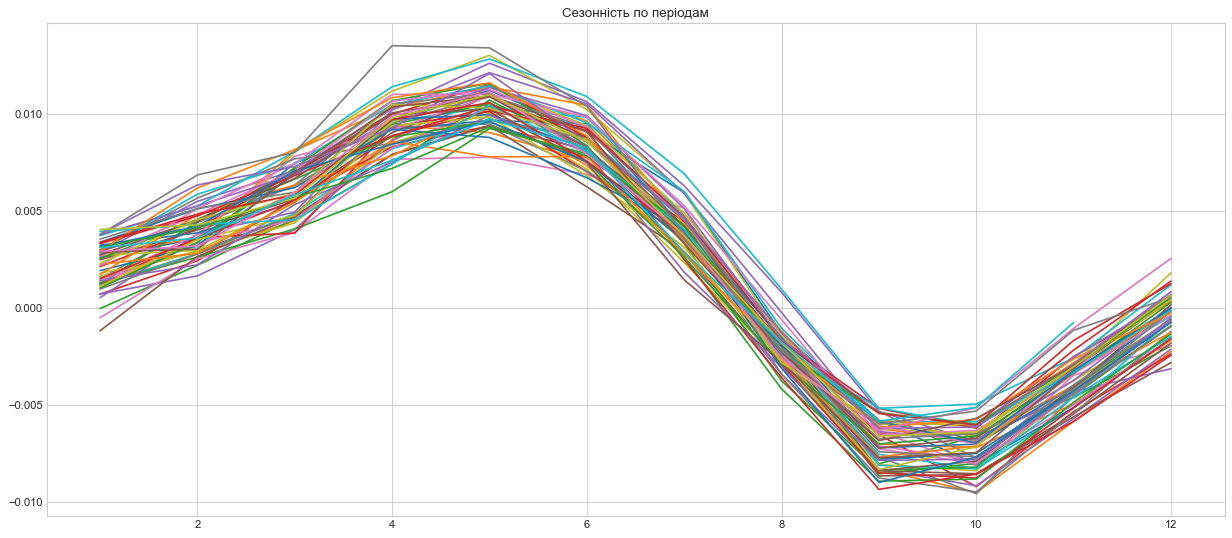

In [14]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    # plt.legend(loc="best")
    plt.show()

sesonal(df_log_mov_av_diff,12)

In [15]:

# ANOMALIES


[<AxesSubplot: >]

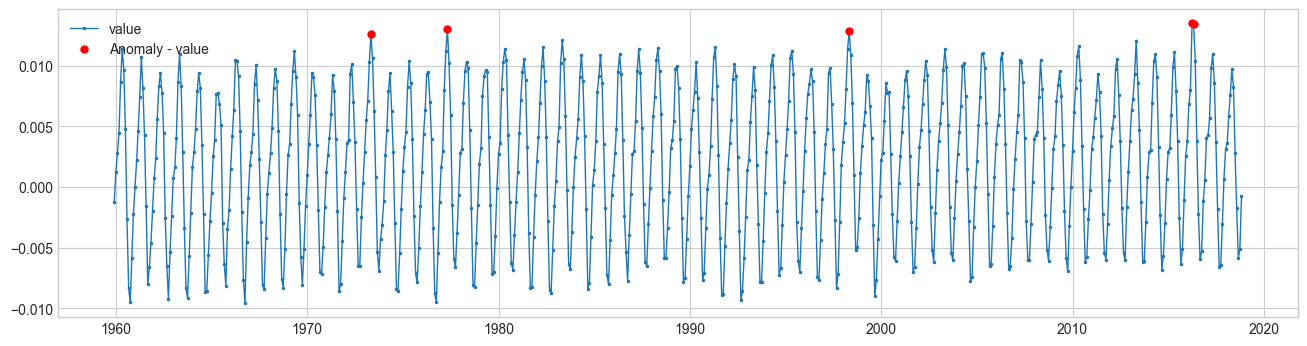

In [16]:
# threshold

from adtk.detector import ThresholdAD

threshold_ad = ThresholdAD(high=0.0125, low=-0.0125)
anomalies = threshold_ad.detect(df_log_mov_av_diff)
plot(df_log_mov_av_diff, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

In [17]:
anomalies[anomalies.value]

,value
date,
1973-05-01,True
1977-05-01,True
1998-05-01,True
2016-04-01,True
2016-05-01,True


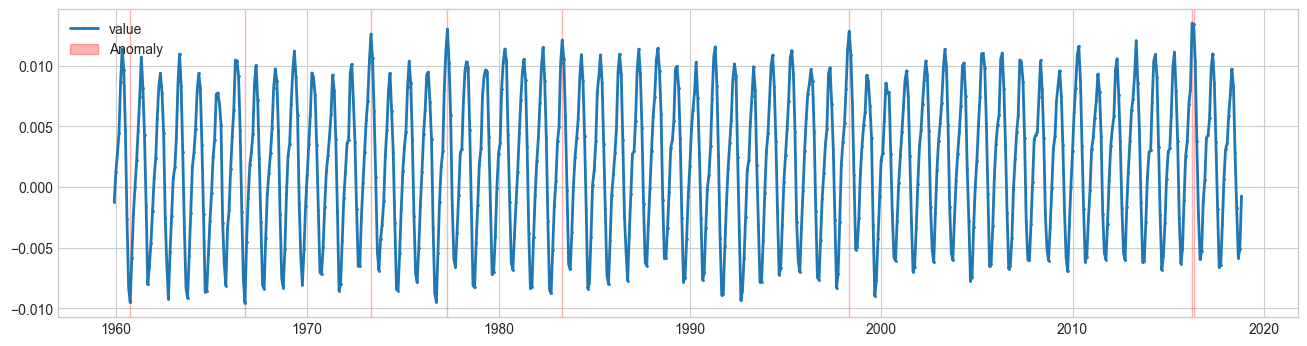

In [18]:
# Outliers

from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.01))
anomalies = outlier_detector.fit_detect(df_log_mov_av_diff)
plot(df_log_mov_av_diff, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [19]:
anomalies[anomalies]

date
1960-10-01    True
1966-10-01    True
1973-05-01    True
1977-05-01    True
1983-05-01    True
1998-05-01    True
2016-04-01    True
2016-05-01    True
dtype: bool

In [20]:

# CORRECTION


In [21]:
df_log_mov_av_diff.loc['1960-10-01']=df_log_mov_av_diff.loc['1960-09-01']
df_log_mov_av_diff.loc['1966-10-01']=df_log_mov_av_diff.loc['1965-10-01']
df_log_mov_av_diff.loc['1973-05-01']=df_log_mov_av_diff.loc['1972-05-01']
df_log_mov_av_diff.loc['1977-05-01']=df_log_mov_av_diff.loc['1976-05-01']
df_log_mov_av_diff.loc['1983-05-01']=df_log_mov_av_diff.loc['1982-05-01']
df_log_mov_av_diff.loc['2016-04-01']=df_log_mov_av_diff.loc['2015-04-01']
df_log_mov_av_diff.loc['2016-05-01']=df_log_mov_av_diff.loc['2015-05-01']


In [22]:

# FORECAST 10 years


In [23]:
df=pd.read_csv("cardox.csv")
df['date'] = pd.to_datetime(df['date'])

train = df[df['date'] < pd.to_datetime("2015-01-01", format='%Y-%m')]
test = df[df['date'] >= pd.to_datetime("2015-01-01", format='%Y-%m')]


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_model = SARIMAX(train['value'], order=(1, 1, 1), seasonal_order=(1,1,1,12)).fit(disp=False)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  682
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -157.263
Date:                            Mon, 15 May 2023   AIC                            324.527
Time:                                    14:29:27   BIC                            347.055
Sample:                                         0   HQIC                           333.253
                                            - 682                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1806      0.092      1.961      0.050    6.41e-05       0.361
ma.L1         -0.5513      0.082   

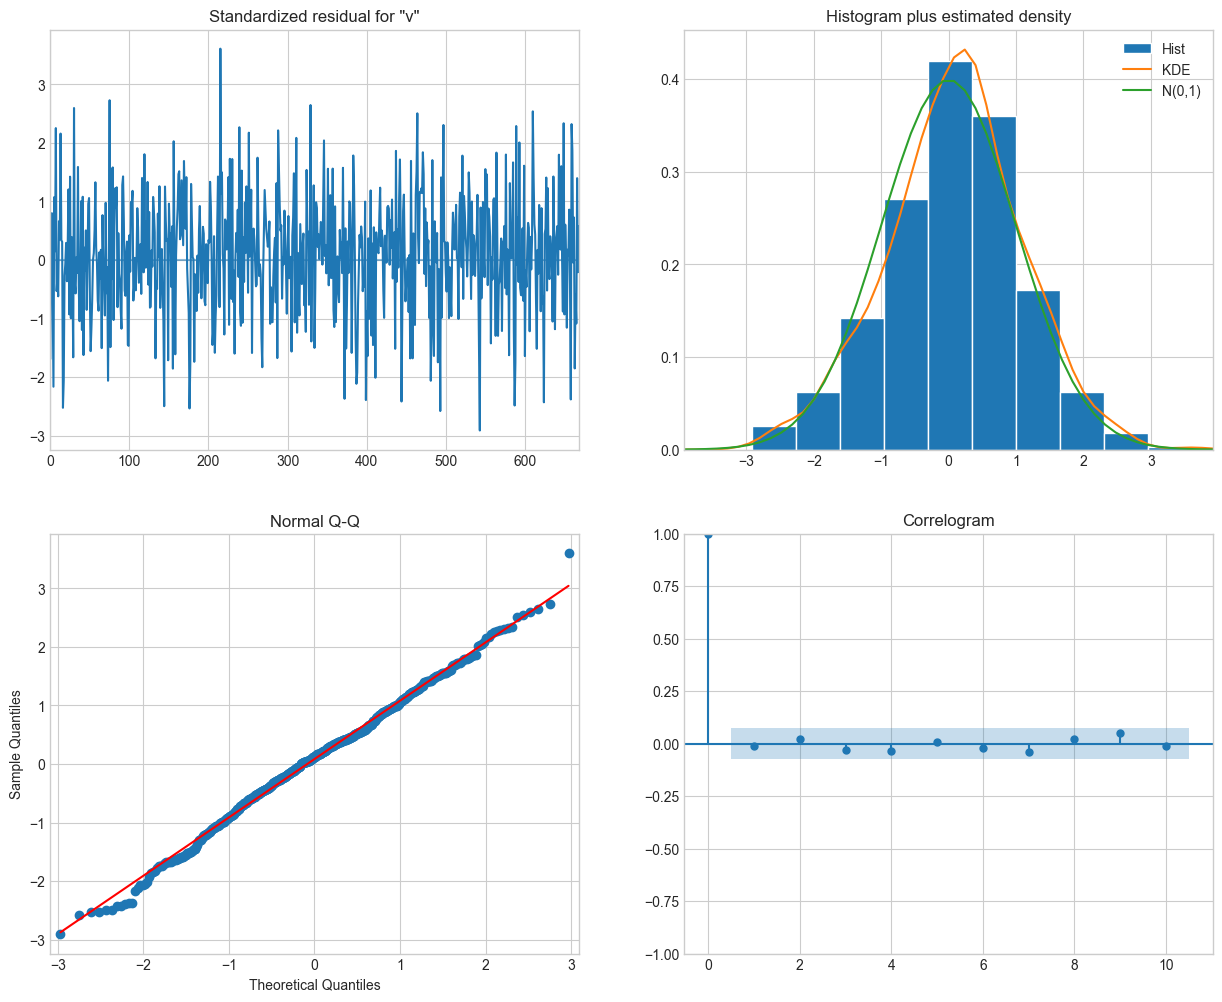

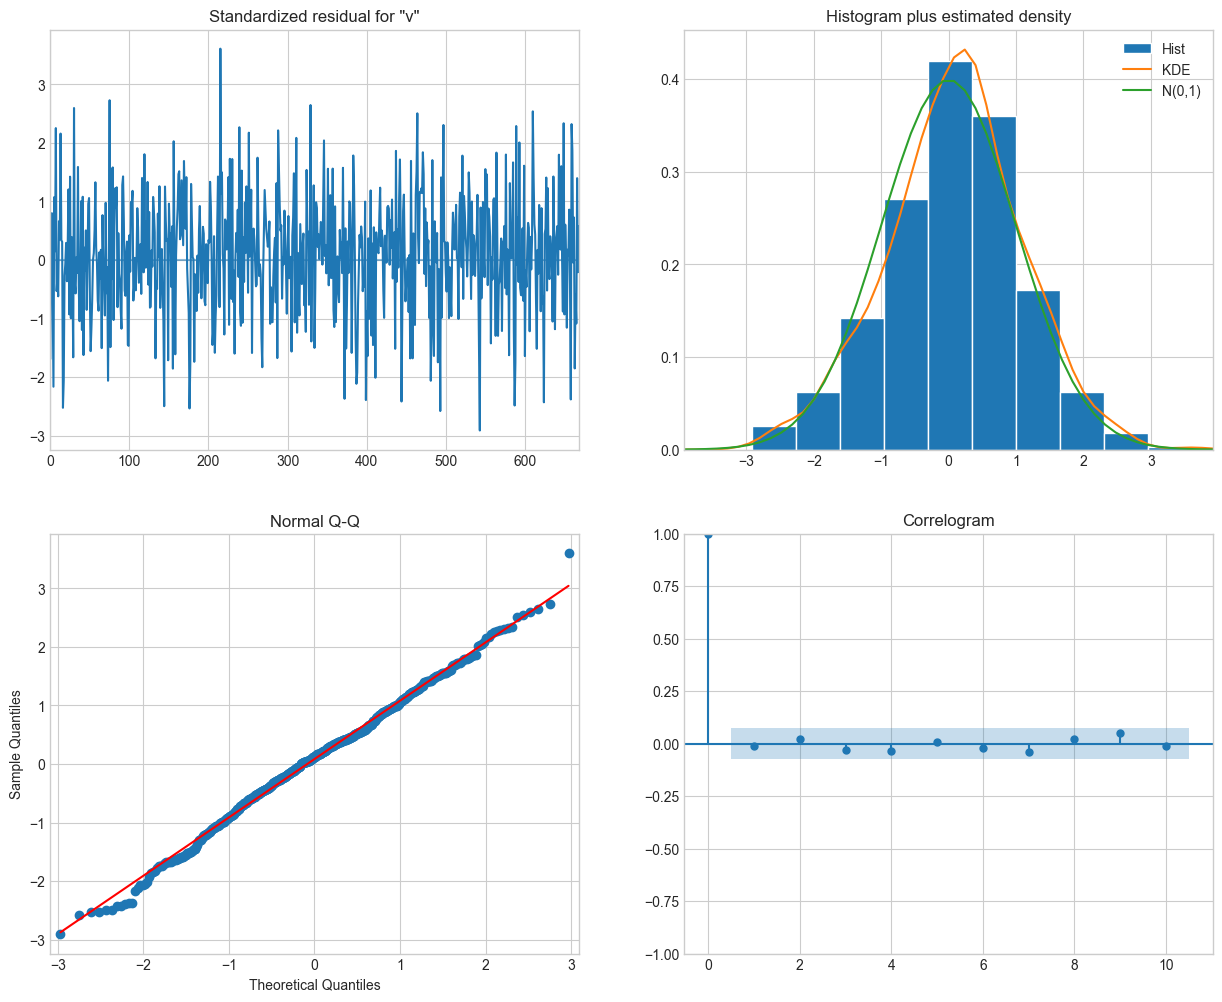

In [25]:
# Diagnosing the model residuals
best_model.plot_diagnostics(figsize=(15,12))

In [26]:
# test prediction
test_predict = best_model.predict(682, 728)
print(test_predict)

682    400.054855
683    400.823090
684    401.713435
685    403.003722
686    403.647797
687    402.949914
688    401.379449
689    399.298363
690    397.843879
691    397.997257
692    399.420090
693    400.898822
694    402.097909
695    402.865690
696    403.773142
697    405.069373
698    405.709226
699    405.014300
700    403.433666
701    401.352775
702    399.894860
703    400.056953
704    401.476753
705    402.958140
706    404.156275
707    404.924064
708    405.831216
709    407.127343
710    407.767270
711    407.072292
712    405.491837
713    403.410942
714    401.953088
715    402.115027
716    403.534881
717    405.016221
718    406.214372
719    406.982162
720    407.889319
721    409.185448
722    409.825373
723    409.130396
724    407.549938
725    405.469043
726    404.011188
727    404.173130
728    405.592982
Name: predicted_mean, dtype: float64


In [27]:
# Forecasting 10 years ahead

forecast = best_model.predict(729, 848)
print(forecast)


729    407.074324
730    408.272475
731    409.040264
732    409.947421
733    411.243550
          ...    
844    428.130959
845    426.050065
846    424.592209
847    424.754152
848    426.174004
Name: predicted_mean, Length: 120, dtype: float64


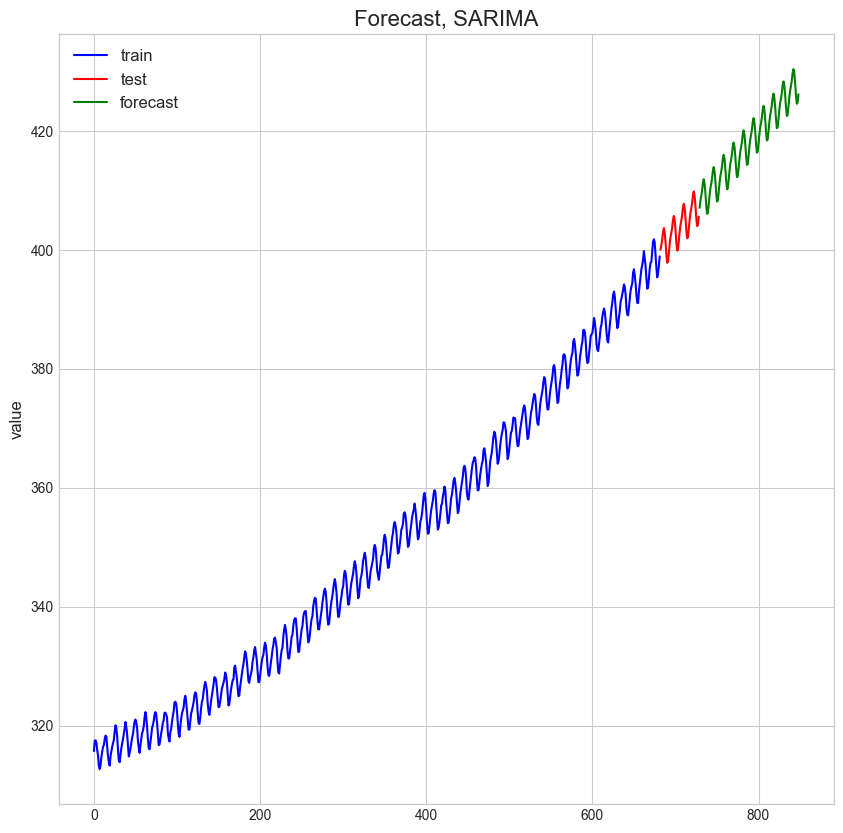

In [28]:
del train['date']

plt.plot(train, color='blue', label='train')
plt.plot(test_predict, color='red', label='test')
plt.plot(forecast, color='green', label='forecast')

plt.title('Forecast, SARIMA', size = 16)
plt.ylabel('value', size=12)
plt.legend(loc='upper left', prop={'size': 12})
